In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
print('import 完成')
#计算距离矩阵,这里返回的矩阵是一个张量
def construct_adjacency_matrix(data1,data2):
    """
    构建邻接矩阵
    """
    # 将数据转换为张量，并移动到GPU上（如果可用）
    data1 = torch.tensor(data1.values).float().to(device)
    data2 = torch.tensor(data2.values).float().to(device)
    # 计算所有数据点之间的距离矩阵
    pairwise_distances = torch.cdist(data1, data2, p=2)  # 计算欧氏距离矩阵
    distances_squared = pairwise_distances.pow(2)  # 距离的平方
    sigma=torch.mean(pairwise_distances)
    similarities = torch.exp(-distances_squared / (2*(sigma ** 2)))  # 高斯核函数计算相似度
    return similarities

#构建类间矩阵
def between_matrix_construct(matrix):

    for i in tqdm(indices_1, desc='类间矩阵'):
        for j in indices_1:
            matrix[i,j]=0
    for p in tqdm(indices_2, desc='类间矩阵'):
        for q in indices_2:
            matrix[p,q]=0
    return matrix

#构建类内矩阵
def zero_matrix(adjacent_matrix,index,len_data):
    for i in tqdm(index,desc='类内矩阵'):
        adjacent_matrix[i,:]=0
        adjacent_matrix[:,i]=0
    return adjacent_matrix

#计算权重矩阵Wii，构建对角线元素，其中对角线元素设为-值，最后返回负值，得到的矩阵matrix为拉普拉斯矩阵
def calculate_diag(matrix):
    # 获取矩阵的行数
    rows, cols = matrix.shape
    # 遍历矩阵的每一行
    for i in tqdm(range(rows),desc='更新对角线元素'):
        # 计算当前行（除对角线元素）的和
        row_sum = matrix[i].sum() - matrix[i, i]
        # 更新对角线元素
        matrix[i, i] = -row_sum
    return -matrix

#读入数据
df=pd.read_csv(r'C:\Users\mls\Desktop\医疗大数据\data_welldisposed_simplify.csv')
readmitted_mapping={0:0,1:0,2:1}
df['readmitted']=df['readmitted'].map(readmitted_mapping)
feature_label=['gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'glyburide-metformin', 'change',
       'diabetesMed']
# 找到需要删除的行的索引
indices_to_drop = []
for id, i in enumerate(df['discharge_disposition_id']):
    if i in [11, 20, 19, 21]:
        indices_to_drop.append(id)
# 删除指定索引的行
df = df.drop(indices_to_drop)
# 重置索引
df = df.reset_index(drop=True)
print('处理后数据量1为', df.shape[0])
#数据预处理部分
#删除重复就诊患者的数据，只保留第一次就诊
df=df.drop_duplicates(subset='patient_nbr',inplace=False)
df = df.reset_index(drop=True)
print('处理后数据量2为',df.shape[0])
min_max_scaler = MinMaxScaler()
df[feature_label] = min_max_scaler.fit_transform(df[feature_label])
#读入数据的条数
len_data=10000
# 获取1和0的数据索引，以便构造三类矩阵
indices_1 = df.index[df['readmitted'] == 1].tolist()
indices_2 = df.index[df['readmitted'] == 0].tolist()
indices_1 = [x for x in indices_1 if x < len_data]
indices_2 = [x for x in indices_2 if x < len_data]
data=df[feature_label].head(len_data)

'''
coef=np.array([[ 0.01248047,  0.06639448, -0.0282276 ,  0.1211645 , -0.02375634,
         0.05291078,  0.00939809, -0.0410713 ,  0.03768097, -0.00803223,
         0.03035206,  0.33367485,  0.04997268,  0.04298992,  0.02948664,
         0.09522829,  0.02480421, -0.03751137, -0.06285053,  0.01141899,
         0.01016457, -0.01738416, -0.00413986, -0.00754439, -0.02845116,
        -0.01422896, -0.01753783, -0.00915579,  0.01115918,  0.09878155]])

df[feature_label] = df[feature_label].multiply(coef, axis=1)
'''
data=df[feature_label].head(len_data)


#batch_size是分割计算时的划分，sigma是在高斯核函数的参数
batch_size=5000
# 使用GPU进行计算,device设为cuda esle cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#初始化距离矩阵,这里的距离矩阵是np矩阵
adjacency_matrix = np.zeros((len_data, len_data),dtype=np.float32)
#调用计算距离矩阵函数，分batch计算距离矩阵
for i in tqdm(range(0,len_data,batch_size),desc='构造邻接矩阵'):
    for j in range(0,len_data,batch_size):
        data_1=data[i:i+batch_size]
        data_2=data[j:j+batch_size]
        adjacency_matrix1=construct_adjacency_matrix(data_1,data_2).cpu().numpy()
        adjacency_matrix[i:i+batch_size,j:j+batch_size]=adjacency_matrix1.copy()
#开始阈值筛选，首先计算行的平均值，代表每个数据点与其他数据点的距离平均值        
row_means = adjacency_matrix.mean(axis=1)
matrix_1=adjacency_matrix.copy()#现在matrix_1是距离矩阵
#分batch进行阈值限制，保存结果为matrix_1，返回值为原来距离
for i in tqdm(range(0,len_data,batch_size),desc='阈值限制1'):
    for j in range(0,len_data,batch_size):
        matrix_1[i:i+batch_size,j:j+batch_size]= np.where(matrix_1[i:i+batch_size,j:j+batch_size] > row_means[i:i+batch_size, np.newaxis],matrix_1[i:i+batch_size,j:j+batch_size], 0)

#分batch进行阈值限制，保存结果为adjacency_matrix，返回值为1,也就是邻接矩阵
for i in tqdm(range(0,len_data,batch_size),desc='阈值限制2'):
    for j in range(0,len_data,batch_size):
        adjacency_matrix[i:i+batch_size,j:j+batch_size]= np.where(adjacency_matrix[i:i+batch_size,j:j+batch_size] > row_means[i:i+batch_size, np.newaxis],1, 0)


matrix_p=zero_matrix(matrix_1.copy(),indices_2,len_data)
matrix_n=zero_matrix(matrix_1,indices_1,len_data)
matrix_between=between_matrix_construct(adjacency_matrix)

matrix_p=calculate_diag(matrix_p)
matrix_n=calculate_diag(matrix_n)
matrix_between=calculate_diag(matrix_between)
print('计算完成，开始疗治')

import 完成
处理后数据量1为 100114
处理后数据量2为 70439


更新对角线元素: 100%|█████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 64528.35it/s]


计算完成，开始疗治


In [2]:
#定义C矩阵
C_ij=(df['readmitted'].head(len_data)==0).sum()/(df['readmitted'].head(len_data)==1).sum()
C=df['readmitted'].head(len_data).copy()
C.replace(1,C_ij,inplace=True)
C.replace(0,1,inplace=True)
C=torch.tensor(C,dtype=torch.float64)

#D=torch.rand(len_data,dtype=torch.float64).to(device)
#定义X矩阵
X=torch.tensor(df[feature_label].values[0:len_data,:],dtype=torch.float64).to(device)
#定义W矩阵,初始化全部为1
W= torch.rand(30,dtype=torch.float64).to(device)
#读入数据
df=pd.read_csv(r'C:\Users\mls\Desktop\医疗大数据\data_welldisposed_simplify.csv')
feature_label=['gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'glyburide-metformin', 'change',
       'diabetesMed']
readmitted_mapping={0:0,1:0,2:1}
df['readmitted']=df['readmitted'].map(readmitted_mapping)
# 找到需要删除的行的索引
indices_to_drop = []
for id, i in enumerate(df['discharge_disposition_id']):
    if i in [11, 20, 19, 21]:
        indices_to_drop.append(id)
# 删除指定索引的行
df = df.drop(indices_to_drop)
# 重置索引
df = df.reset_index(drop=True)
print('处理后数据量1为', df.shape[0])
#数据预处理部分
#删除重复就诊患者的数据，只保留第一次就诊
df=df.drop_duplicates(subset='patient_nbr',inplace=False)
df = df.reset_index(drop=True)
#定义D矩阵（标签增强矩阵）,这里定义了device
D=torch.tensor(df['readmitted'][0:len_data]/2,dtype=torch.float64).to(device)

# W 的求导定义
#定义U矩阵求解
def U_calculate(matrix):
    diag_m=torch.diag(matrix)
    return diag_m


#定义W的范数求解
def L_calculate(tensor):
    # 计算张量中每个元素的倒数的一半
    reciprocal_half_tensor =0.5*torch.reciprocal(tensor*tensor)
    # 构造对角矩阵
    diagonal_matrix = torch.diag(reciprocal_half_tensor)
    return diagonal_matrix


#定义D的限制条件
def D_cons(tensor):
    # 将大于1的值变为1
    tensor[tensor > 1] = 1
    # 将小于0的值变为0
    tensor[tensor < 0] = 0
    return tensor

def auc_calculate(matrix,len_data,len):
    matrix_W=matrix.clone().to('cpu').numpy()
    df_matrix=np.asarray(df[feature_label].values[int(len_data):int(len_data+len),:])
    pre_prob=df_matrix@(matrix_W.T)
    auc=roc_auc_score(df['readmitted'][int(len_data):int(len_data+len)],pre_prob)
    return auc

# D 的求导定义
gama=10
alpha=0.5
beta=0.2
#初始值定义
X=X.to(device)
D=D.to(device)
U=U_calculate(C).to(device)
L=L_calculate(W).to(device)


处理后数据量1为 100114


In [20]:
W

tensor([ 0.0000e+00,  4.3416e-01, -5.0632e-01,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.7745e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -2.0766e-16,  2.1026e-16, -6.0450e-16,
         2.2974e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       device='cuda:0', dtype=torch.float64)

In [12]:
W

tensor([ 0.0000e+00,  8.4315e-01, -9.7395e-01,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.4062e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.5101e-15,  4.3421e-16, -3.9859e-16,
         4.5188e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.2281e+00],
       device='cuda:0', dtype=torch.float64)

In [15]:
np.save('W_权重矩阵.npy', W.cpu())

In [16]:
np.save('D_数值标签.npy',D.cpu())

In [ ]:
tensor([ 0.0000e+00,  8.4315e-01, -9.7395e-01,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.4062e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.5101e-15,  4.3421e-16, -3.9859e-16,
         4.5188e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.2281e+00],
       device='cuda:0', dtype=torch.float64)

[0.5        0.5361236  0.55725455 0.5722472  0.5838764  0.59337815
 0.60141176 0.6083708  0.6145091  0.62       0.62496712 0.62950175
 0.6336732  0.63753536 0.64113095 0.6444944  0.64765387 0.6506327
 0.65345043 0.6561236  0.65866632 0.66109072 0.66340734 0.66562535
 0.6677528  0.6697968  0.67176365 0.67365896 0.67548776 0.67725455
 0.6789634  0.680618   0.68222167 0.68377747 0.68528817 0.6867563
 0.68818421 0.68957403 0.69092775 0.6922472  0.69353406 0.69478991
 0.69601621 0.69721432 0.6983855  0.69953094 0.70065174 0.70174895
 0.70282353 0.7038764  0.70490842 0.7059204  0.7069131  0.70788725
 0.70884352 0.70978256 0.71070498 0.71161136 0.71250224 0.71337815
 0.71423958 0.715087   0.71592087 0.7167416  0.7175496  0.71834527
 0.71912898 0.71990107 0.72066189 0.72141176 0.722151   0.7228799
 0.72359874 0.72430781 0.72500735 0.72569763 0.72637889 0.72705135
 0.72771525 0.7283708  0.7290182  0.72965766 0.73028937 0.73091351
 0.73153027 0.73213981 0.73274231 0.73333792 0.7339268  0.7345091

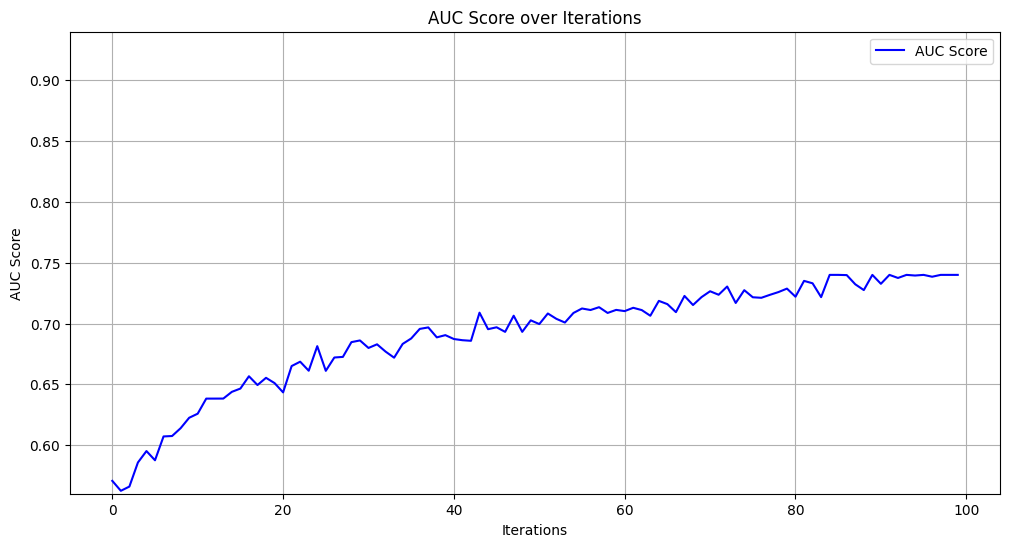

In [16]:
import matplotlib.pyplot as plt
matrix_p = torch.tensor(matrix_p, dtype=torch.float64).to(device)
matrix_between = torch.tensor(matrix_between, dtype=torch.float64).to(device)

# 创建初始图形
plt.figure()
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('Real-time AUC during iterations')
plt.grid(True)

# step 1 更新W
iterations = 1000
auc_values = []
for i in range(iterations):
    W = (torch.linalg.inv((X.T)@(U.T)@U@X + gama*L))@(X.T)@(U.T)@U@D
    L = L_calculate(W)
    D = (torch.linalg.inv((U.T)@U + alpha*matrix_p + beta*matrix_between))@(U.T)@U@X@W
    D = D_cons(D)
    auc = auc_calculate(W, len_data,1000)
    auc_values.append(auc)
    # 实时绘制AUC折线图
    plt.plot(range(i+1), auc_values, marker='o', color='blue')  # 更新折线图数据
    plt.pause(0.1)  # 暂停一小段时间以更新图形

plt.show()  # 显示最终的AUC折线图

In [ ]:
learning_rate=0.000001
iterations=30
matrix_p=torch.tensor(matrix_p,dtype=torch.float64).to(device)
matrix_between=torch.tensor(matrix_between,dtype=torch.float64).to(device)
for i in range(iterations):
    Gra_W=(X.T)@(U.T)@(U@X@W-U@D)+gama*L@W
    W=W-Gra_W*learning_rate
    Gra_D=(U.T)@(U@X@W-U@D)+alpha*matrix_p@D+beta*matrix_between@D
    D=D-Gra_D*learning_rate
    #D=D_cons(D)
    print(auc_calculate(W,len_data))